In [1]:
# Solidware Mini-Project Task
# 
# Start time - 00:04, Wed, December 5th 2018 (Melbourne Local Time)
# End time -   02:02, Wed, December 5th 2018 (Melbourne Local Time)
#
# by ezra

#### Introduction

Since I move quickly in Python I choose to use Python 3 for this task

<br> I also wanted to use the Jupyter Enviorment in order to communicate myself better in the markdown
<br> Before starting lets import the libraries in the below cell

In [2]:
import urllib.request as req                                                 # for data pulling
import pandas as pd                                                          # dataframe manipulation 
import seaborn as sns                                                        # plotting
from mlxtend.feature_selection import SequentialFeatureSelector as SFS       # forward feature selection
from sklearn.model_selection import train_test_split                         # test train splitting
from sklearn.linear_model import LinearRegression                            # linear regression 
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs   # plotting the forward feature selections
import matplotlib.pyplot as plt                                              # plotting
from sklearn.metrics import mean_squared_error                               # error 

pd.options.mode.chained_assignment = None                                    # default='warn' / I turn this off not to get chained assignment warnings in pandas
%matplotlib inline

#### 1) The data

Pulling the data from the url source. Headers are said to be missing. For clarity purposes adding headers. Dropping the syboling column as the task says to ignore. Lastly, displaying the head of the dataframe. 

In [3]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"
req.urlretrieve(URL, "myFile.csv")
data = pd.read_csv("myFile.csv")
data.columns = ["symboling", "normalized_losses", "make", "fule_type", "aspiration", "num_of_doors", "body_style", 
                "drive_wheels", "engine_location", "wheel_base", "length", "width", "height", "curb_weight", "engine_type",
               "num_of_cylinders", "engine_size", "fuel_system", "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm",
               "city_mpg", "highway_mpg", "price"]

data = data.drop("symboling", axis = 1) # task says to ignore 
data.head()

,normalized_losses,make,fule_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,?,audi,gas,std,two,sedan,fwd,front,99.8,177.3,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


#### 2) Explore 

The data holds:

-  9 numerical variables
-  16 categorical variables 

The target variable is considered as a categorical variable for the time being. 
<br> The dataset is holds no null value (other then the '?' in the normalized_losses column). 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 25 columns):
normalized_losses    204 non-null object
make                 204 non-null object
fule_type            204 non-null object
aspiration           204 non-null object
num_of_doors         204 non-null object
body_style           204 non-null object
drive_wheels         204 non-null object
engine_location      204 non-null object
wheel_base           204 non-null float64
length               204 non-null float64
width                204 non-null float64
height               204 non-null float64
curb_weight          204 non-null int64
engine_type          204 non-null object
num_of_cylinders     204 non-null object
engine_size          204 non-null int64
fuel_system          204 non-null object
bore                 204 non-null object
stroke               204 non-null object
compression_ratio    204 non-null float64
horsepower           204 non-null object
peak_rpm             204 non-nu

Fixing the type of the 'normalized_losses' column to float64.
<br> This new look at the data suggest that the target variable has 40 missing instances.
<br> As this is a regression exercise, let us first separate the Null rows from the Filled in ones.   

In [5]:
data.normalized_losses = pd.to_numeric(data.normalized_losses, errors='coerce')

# splitting the dataset #

null_data = data [list(pd.isna(data.normalized_losses))]  # (40 rows)  of the normalized_losses that have the ? value  
full_data = data [list(pd.notna(data.normalized_losses))] # (164 rows) of the normalized_losses that have an actual value  

full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 2 to 203
Data columns (total 25 columns):
normalized_losses    164 non-null float64
make                 164 non-null object
fule_type            164 non-null object
aspiration           164 non-null object
num_of_doors         164 non-null object
body_style           164 non-null object
drive_wheels         164 non-null object
engine_location      164 non-null object
wheel_base           164 non-null float64
length               164 non-null float64
width                164 non-null float64
height               164 non-null float64
curb_weight          164 non-null int64
engine_type          164 non-null object
num_of_cylinders     164 non-null object
engine_size          164 non-null int64
fuel_system          164 non-null object
bore                 164 non-null object
stroke               164 non-null object
compression_ratio    164 non-null float64
horsepower           164 non-null object
peak_rpm             164 non-n

The full_data is not really 'full'. Reason being, is that it still has ? values in it. 
<br> This is easily noticeable as types are still wrong.
<br> As an example the price column still looks like an object not a numeric. 
<br> So lets impute these values with the column's mean value.

<br> 
<br> The columns of interest are: bore, stroke, horsepower, peak_rpm & price


In [6]:
full_data.bore = pd.to_numeric(full_data.bore, errors='coerce')
full_data.stroke = pd.to_numeric(full_data.stroke, errors='coerce')
full_data.horsepower = pd.to_numeric(full_data.horsepower, errors='coerce')
full_data.peak_rpm = pd.to_numeric(full_data.peak_rpm, errors='coerce')
full_data.price = pd.to_numeric(full_data.price, errors='coerce')

full_data.bore = full_data.bore.fillna(full_data["bore"].mean())
full_data.stroke = full_data.stroke.fillna(full_data["stroke"].mean())
full_data.horsepower = full_data.horsepower.fillna(full_data["horsepower"].mean())
full_data.peak_rpm = full_data.peak_rpm.fillna(full_data["peak_rpm"].mean())
full_data.price = full_data.price.fillna(full_data["price"].mean())

Let's now check for "?" in the categorical data

In [7]:
for i in list(full_data.columns):
    if '?' in list(full_data[i]):
        print (i)

num_of_doors


mini script above suggests that only the "num_of_doors" column has a ? in it.
<br> let us quickly see what is appropriate to impute this value with

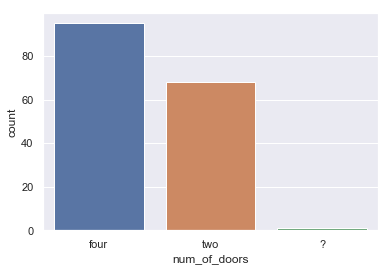

In [8]:
sns.set(style="darkgrid") # style choice 

sns.countplot( x = "num_of_doors", data = full_data)

Choose to impute with four, as has majority

In [9]:
full_data.num_of_doors = full_data.num_of_doors.replace('?','four')

In [10]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 2 to 203
Data columns (total 25 columns):
normalized_losses    164 non-null float64
make                 164 non-null object
fule_type            164 non-null object
aspiration           164 non-null object
num_of_doors         164 non-null object
body_style           164 non-null object
drive_wheels         164 non-null object
engine_location      164 non-null object
wheel_base           164 non-null float64
length               164 non-null float64
width                164 non-null float64
height               164 non-null float64
curb_weight          164 non-null int64
engine_type          164 non-null object
num_of_cylinders     164 non-null object
engine_size          164 non-null int64
fuel_system          164 non-null object
bore                 164 non-null float64
stroke               164 non-null float64
compression_ratio    164 non-null float64
horsepower           164 non-null int64
peak_rpm             164 non-

#### 3) Dealing with the Categorical Data

Now we have the full data. 
<br> Before we move on to the modelling, we need to take care of the categorical variables.
<br> Pandas makes this easy for us by the _getdummies_ method

In [11]:
dummies = pd.get_dummies(full_data[['make', 'fule_type', 'aspiration', 'num_of_doors', 'body_style', 'drive_wheels', 'engine_location',
                                           'engine_type', 'num_of_cylinders', 'fuel_system']])

print(dummies.shape)

(164, 52)


In [12]:
dummies.head()

,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_jaguar,make_mazda,make_mercedes-benz,make_mitsubishi,make_nissan,...,num_of_cylinders_six,num_of_cylinders_three,num_of_cylinders_two,fuel_system_1bbl,fuel_system_2bbl,fuel_system_4bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### This created several dummy variables for us.. lets now create our Y vector and X matrix

In [13]:
y = full_data.normalized_losses
# Dropping the categorical values also the target variable 
temp = full_data.drop(['normalized_losses','make', 'fule_type', 'aspiration', 'num_of_doors', 'body_style', 'drive_wheels', 'engine_location',
                                           'engine_type', 'num_of_cylinders', 'fuel_system'], axis=1).astype('float64')
# Creating the final feature set by joining the two dataframes via concat
X = pd.concat([temp, dummies], axis=1)

In [14]:
X.head()

,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,...,num_of_cylinders_six,num_of_cylinders_three,num_of_cylinders_two,fuel_system_1bbl,fuel_system_2bbl,fuel_system_4bbl,fuel_system_idi,fuel_system_mfi,fuel_system_mpfi,fuel_system_spdi
2,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.4,10.0,102.0,...,0,0,0,0,0,0,0,0,1,0
3,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.4,8.0,115.0,...,0,0,0,0,0,0,0,0,1,0
5,105.8,192.7,71.4,55.7,2844.0,136.0,3.19,3.4,8.5,110.0,...,0,0,0,0,0,0,0,0,1,0
7,105.8,192.7,71.4,55.9,3086.0,131.0,3.13,3.4,8.3,140.0,...,0,0,0,0,0,0,0,0,1,0
9,101.2,176.8,64.8,54.3,2395.0,108.0,3.50,2.8,8.8,101.0,...,0,0,0,0,0,0,0,0,1,0


#### 4) Modelling

Checking Linearity for Linear Regression 

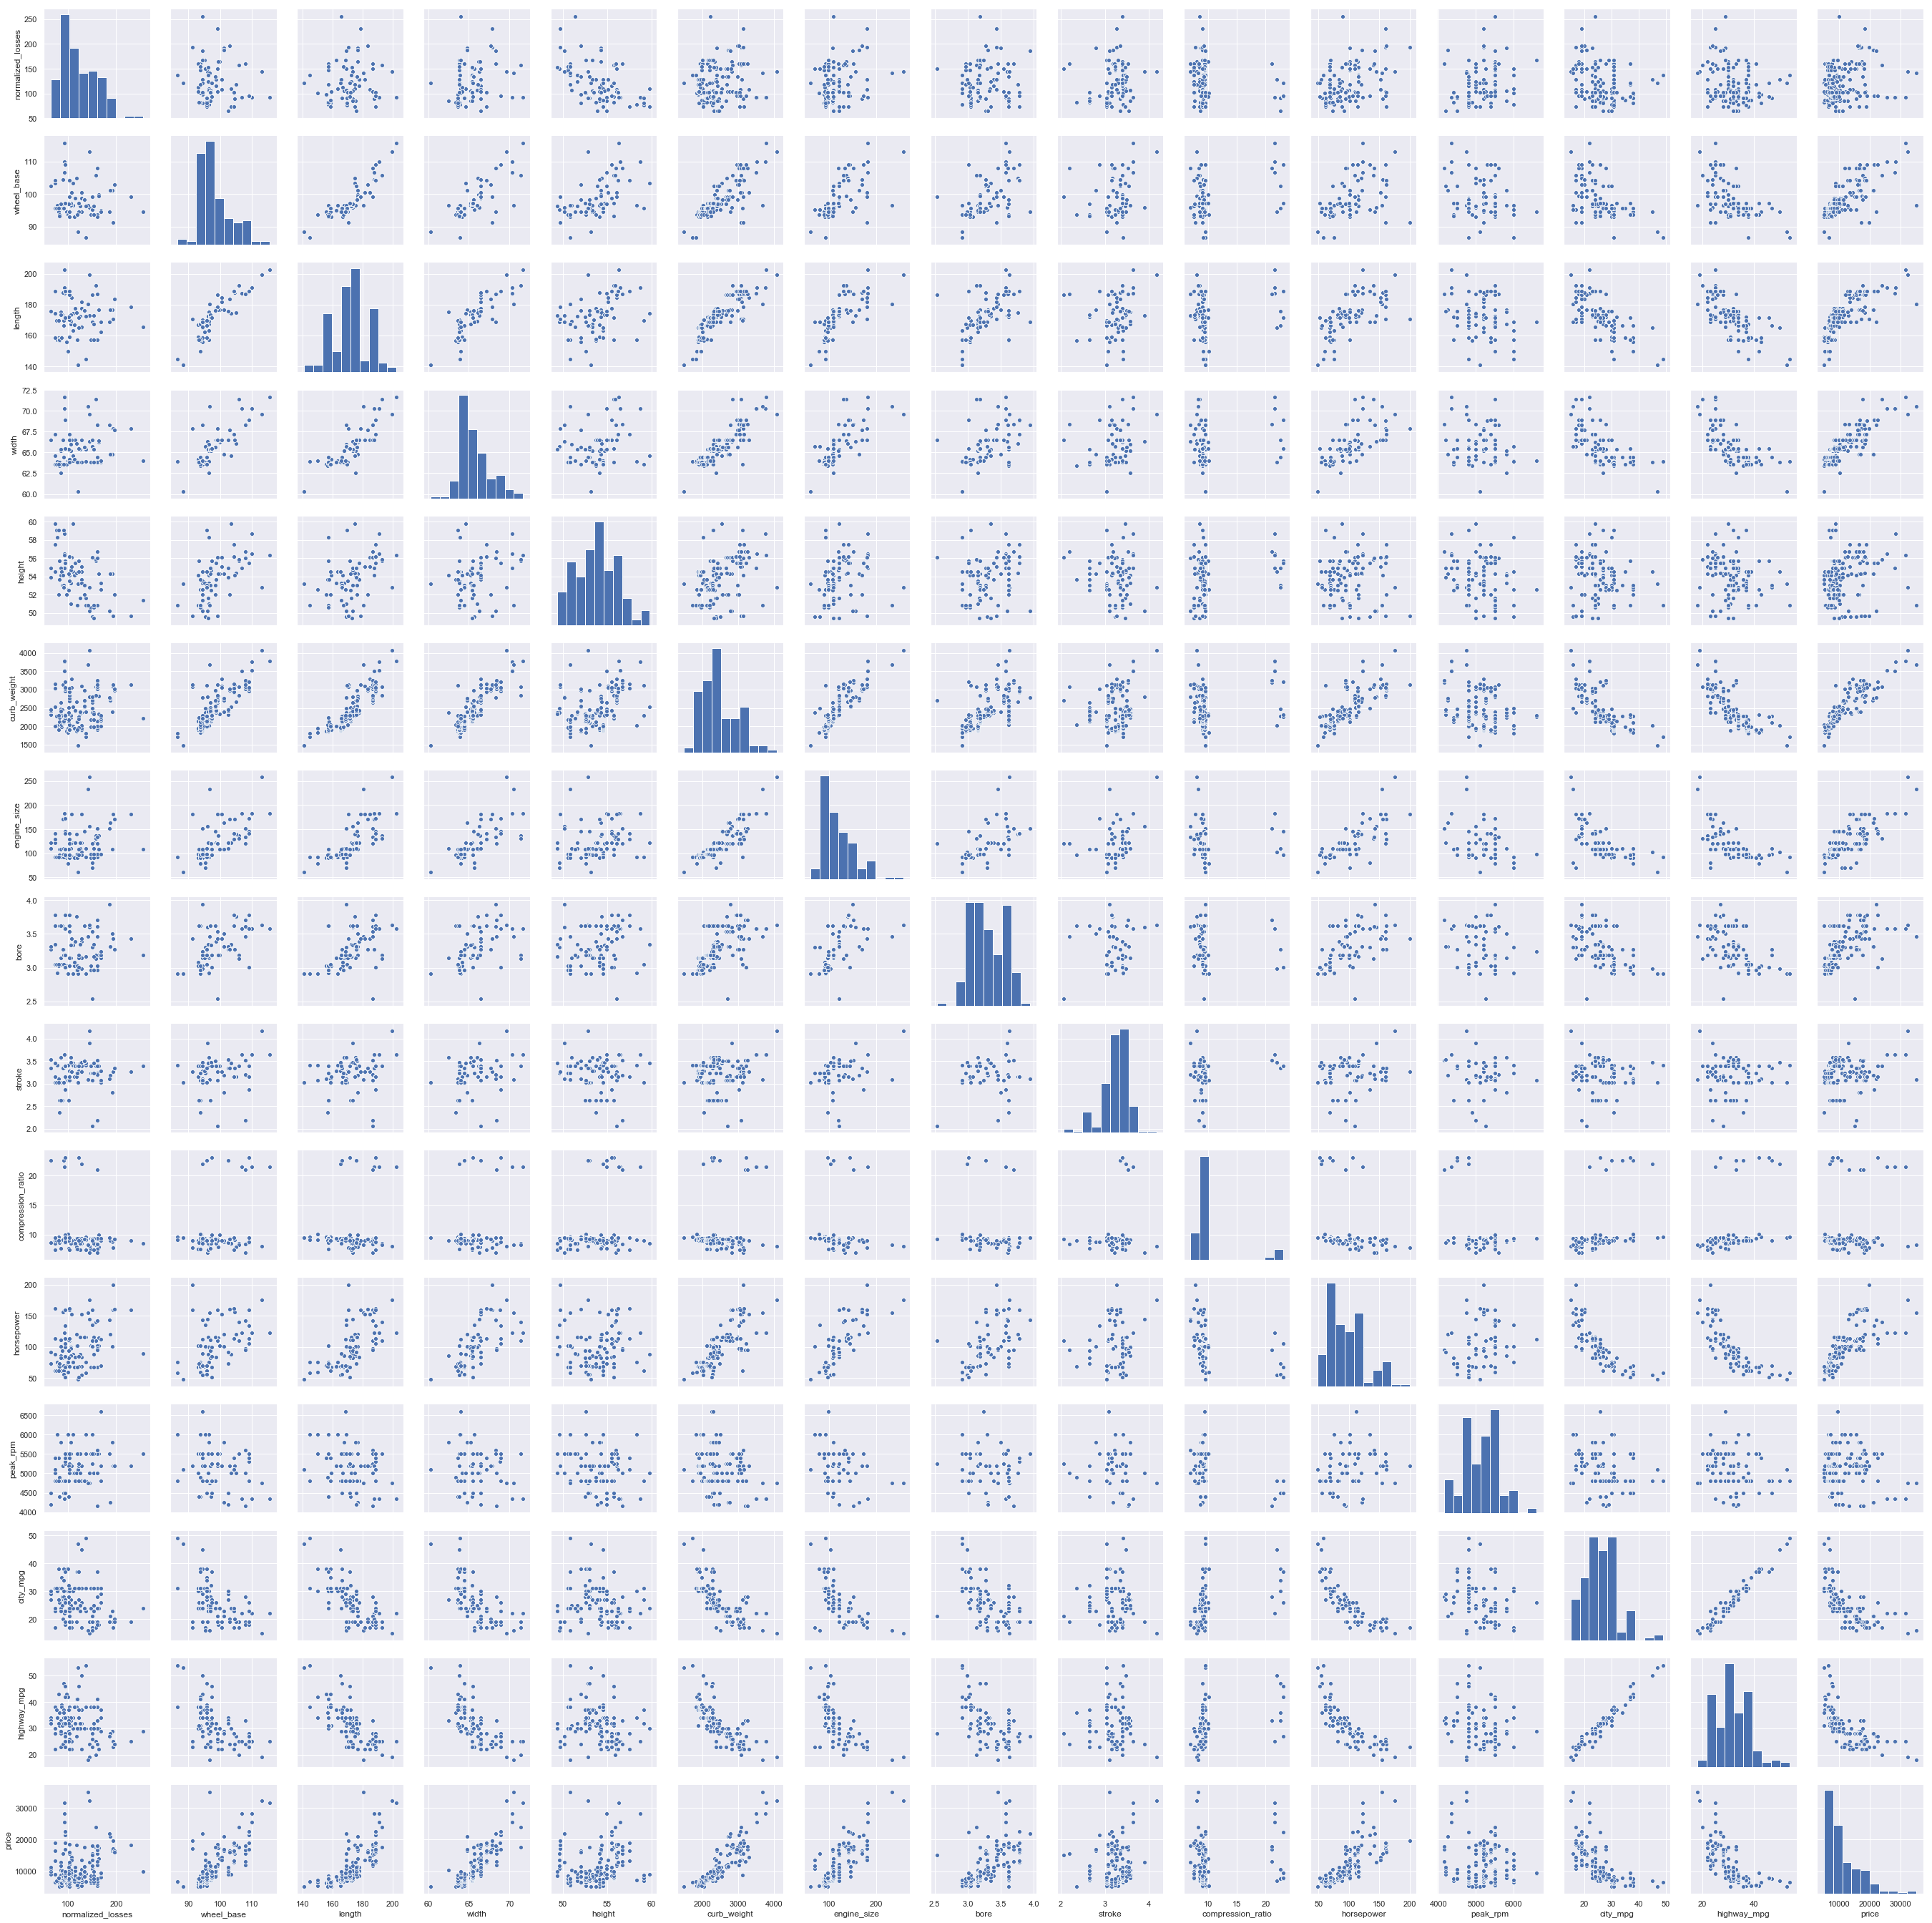

In [15]:
sns.pairplot(full_data)

linearity checks out if you check the first row of the plot array, one can see the target variable plotted against the rest. Several attributes tend to show some sort of linearity with the target. Now we go into picking the best feature combo for the model by using the exhaustive best subset method. If this method is too computationally expensive you can always revert to other libraries or forward or backward stepwise selection.  

<br> The below code creates a forward stepwise feature selector. Although it is not ideal, 66 features are too much for my laptop to run a best subset selection. 

<br> This model evaluates this by a the K-fold technique which K is set to 20 splits. The metric is MSE (as requested in the PDF sent by Solidware) 
<br> For the plots to be easily readable I invert the the MSE to a negative MSE

In [16]:
sfs = SFS(LinearRegression(), k_features = 66, forward= True, scoring='neg_mean_squared_error', cv=20)

In [17]:
feature_names = list(X.columns)
sfs.fit(X, y, custom_feature_names=feature_names)

SequentialFeatureSelector(clone_estimator=True, cv=20,
             estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
             floating=False, forward=True, k_features=66, n_jobs=1,
             pre_dispatch='2*n_jobs', scoring='neg_mean_squared_error',
             verbose=0)

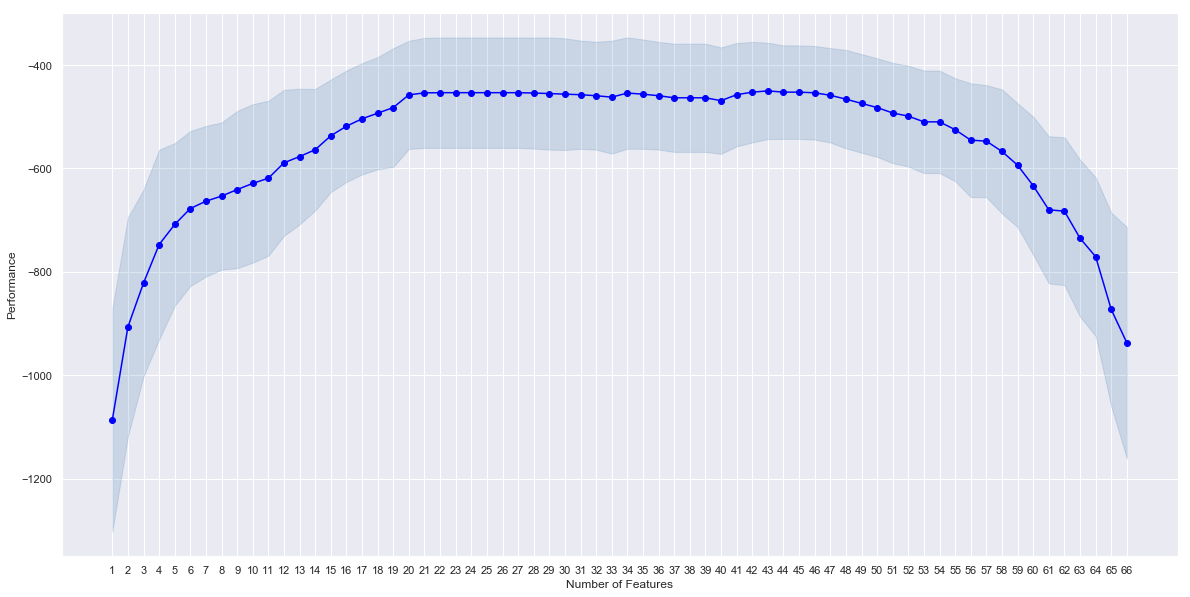

In [18]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
fig.set_size_inches((20,10))

Plot above gives the negative MSE vs number of features used. The spread around the graph shows the standard error. As expected both low and a high number of features give worse results. Below is a small script that gives us the lowest MSE

#### 4) Some Inference

In [19]:
neg_mse = []

for i in range (1,67):
    
    neg_mse.append(sfs.get_metric_dict()[i]["avg_score"])
    
sfs.get_metric_dict()[neg_mse.index(max(neg_mse))]

{'avg_score': -452.44296039232347,
 'ci_bound': 202.8390759948985,
 'cv_scores': array([-1073.37054205,  -709.34696257,  -680.1419934 ,  -450.7998382 ,
         -475.69030903,  -369.89300456,  -146.16076384,   -33.42907079,
         -408.122979  ,  -274.64753419,  -468.79424972,  -215.38513395,
         -232.24072644,   -41.17440712,  -299.71091694,  -224.0673683 ,
         -249.11860657,  -694.02014845, -1930.7532753 ,   -71.99137742]),
 'feature_idx': (0,
  1,
  3,
  7,
  8,
  10,
  11,
  14,
  15,
  16,
  18,
  19,
  20,
  21,
  24,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  36,
  37,
  40,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  52,
  54,
  56,
  58,
  59,
  61,
  62,
  63),
 'feature_names': ('wheel_base',
  'length',
  'height',
  'stroke',
  'compression_ratio',
  'peak_rpm',
  'city_mpg',
  'make_audi',
  'make_bmw',
  'make_chevrolet',
  'make_honda',
  'make_jaguar',
  'make_mazda',
  'make_mercedes-benz',
  'make_peugot',
  'make_porsche',
  'make_saab',
  '

Below one can see the best combo of features according to the forward feature selector

In [20]:
(sfs.get_metric_dict()[neg_mse.index(max(neg_mse))]["feature_names"])

('wheel_base',
 'length',
 'height',
 'stroke',
 'compression_ratio',
 'peak_rpm',
 'city_mpg',
 'make_audi',
 'make_bmw',
 'make_chevrolet',
 'make_honda',
 'make_jaguar',
 'make_mazda',
 'make_mercedes-benz',
 'make_peugot',
 'make_porsche',
 'make_saab',
 'make_subaru',
 'make_toyota',
 'make_volkswagen',
 'make_volvo',
 'fule_type_diesel',
 'fule_type_gas',
 'num_of_doors_four',
 'num_of_doors_two',
 'body_style_hatchback',
 'drive_wheels_4wd',
 'drive_wheels_fwd',
 'drive_wheels_rwd',
 'engine_location_front',
 'engine_type_dohc',
 'engine_type_l',
 'engine_type_ohc',
 'engine_type_ohcf',
 'engine_type_rotor',
 'num_of_cylinders_five',
 'num_of_cylinders_six',
 'num_of_cylinders_two',
 'fuel_system_1bbl',
 'fuel_system_4bbl',
 'fuel_system_idi',
 'fuel_system_mfi')

The above 'best' combo has 42 variables. According to the graph we can see the plato happening around 20 variables. Let's see the average MSE difference between the best model for 42 and and 20 variables.

In [21]:
sfs.get_metric_dict()[42]['avg_score'] - sfs.get_metric_dict()[20]['avg_score']

5.166167346422299

There isn't much difference. Therefore I favor the one with less variables, i.e. the model with 20 variables. Below, one can see the features used;

In [22]:
(sfs.get_metric_dict()[20]["feature_names"])

('height',
 'peak_rpm',
 'city_mpg',
 'make_audi',
 'make_bmw',
 'make_chevrolet',
 'make_honda',
 'make_peugot',
 'make_saab',
 'make_toyota',
 'make_volvo',
 'num_of_doors_two',
 'body_style_hatchback',
 'drive_wheels_4wd',
 'drive_wheels_rwd',
 'engine_type_l',
 'engine_type_ohc',
 'engine_type_ohcf',
 'num_of_cylinders_six',
 'fuel_system_4bbl')

#### 5) Creating Final Model

Now that we have decided what features to use, let us create the regression model making use of these 20 features 

In [23]:
X_20 = X[list(sfs.get_metric_dict()[20]["feature_names"])]
X_20.head()

,height,peak_rpm,city_mpg,make_audi,make_bmw,make_chevrolet,make_honda,make_peugot,make_saab,make_toyota,make_volvo,num_of_doors_two,body_style_hatchback,drive_wheels_4wd,drive_wheels_rwd,engine_type_l,engine_type_ohc,engine_type_ohcf,num_of_cylinders_six,fuel_system_4bbl
2,54.3,5500.0,24.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,54.3,5500.0,18.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
5,55.7,5500.0,19.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,55.9,5500.0,17.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,54.3,5800.0,23.0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_20, y, test_size=0.10, random_state=42)
final_fit = LinearRegression()
final_fit.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Lets see the MSE of the predictions of this random split

In [25]:
predictions   = final_fit.predict(X_test)
y_groundTruth = y_test
mean_squared_error(y_groundTruth, predictions)

208.69489356770208

In [26]:
prediction_dataframe = pd.DataFrame(columns=['ground_truth', 'predictions'])
prediction_dataframe.ground_truth = y_groundTruth
prediction_dataframe.predictions  = [round(i) for i in predictions]

#### final dataframe below for the test set of this regression problem 

In [27]:
prediction_dataframe

,ground_truth,predictions
170,134.0,141.0
150,87.0,102.0
166,134.0,143.0
76,161.0,153.0
124,186.0,180.0
38,85.0,91.0
197,103.0,80.0
68,93.0,134.0
136,104.0,118.0
181,122.0,116.0


In [ ]:
# end.